Importations

In [1]:
import json
import string
import tensorflow as tf
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [18]:
pathfile = "C:/Users/polin/Documents/IMT/Cours actuels/Projet ML/Sarcasm_Headlines_Dataset.json"
data = []
for line in open(pathfile, 'r'):
    data.append(json.loads(line))
titres, sarcastique = [], []

In [ ]:
df=pd.DataFrame(data)
del df["article_link"]

In [ ]:
df.isna().sum()

In [19]:
df['is_sarcastic'].value_counts()
titres_train, titres_test, sarcastique_train, sarcastique_test =train_test_split(df["headline"], df["is_sarcastic"], test_size=0.33)

df1=pd.DataFrame(titres_train)
df1=df1.rename(columns={0:'headline'})

df2=pd.DataFrame(sarcastique_train)
df2=df2.rename(columns={0:'is_sarcastic'})
df_train=pd.concat([df1,df2],axis=1)

df3=pd.DataFrame(titres_test)
df3=df3.rename(columns={0:'headline'})

df4=pd.DataFrame(sarcastique_test)
df4=df4.rename(columns={0:'is_sarcastic'})

df_test=pd.concat([df3,df4],axis=1)

In [20]:
print(len(titres_test))
print(df_train)

8814
                                                headline  is_sarcastic
26442         i was taught to be ashamed of my sexuality             0
22724  j.d. vance: republican presidential nominee in...             0
10330  the soul's ingredients: the secret to summonin...             0
13266  losing-powerball-numbers announcement enters 1...             1
5917    painting of jesus totally knows area man is high             1
...                                                  ...           ...
19035  want to be ready for retirement? lower your ex...             0
14701  panicked studio delays 'man of steel' to get m...             1
4337                        ebola, aids, and plague inc.             0
1346   report: 250 million americans still need guest...             1
9807   trump administration suddenly pulls plug on te...             0

[17895 rows x 2 columns]


In [21]:
def remove_punctuation(text):
    text=text.replace("\'s","")
    text=text.replace("\'m","")
    text=text.replace("\'ve","")
    text=text.replace("\'","")
    text=text.replace(",","")
    text=text.replace("-"," ")
    text=text.replace(":","")
    text=text.replace(".","")
    text=text.replace(";","")
    text=text.replace("!","")
    text=text.replace("?","")
    return text

df_train['headline']= df_train['headline'].apply(lambda x:remove_punctuation(x))
df_test['headline']= df_test['headline'].apply(lambda x:remove_punctuation(x))

In [22]:
df_train

,headline,is_sarcastic
26442,i was taught to be ashamed of my sexuality,0
22724,jd vance republican presidential nominee in 2032,0
10330,the soul ingredients the secret to summoning y...,0
13266,losing powerball numbers announcement enters 1...,1
5917,painting of jesus totally knows area man is high,1
...,...,...
19035,want to be ready for retirement lower your exp...,0
14701,panicked studio delays an of steel to get more...,1
4337,ebola aids and plague inc,0
1346,report 250 million americans still need guests...,1


In [23]:
def generate_ngrams(text, ngram=1):
    tokens=[
        token for token in text.split(" ") if token not in set(stopwords.words('english'))
    ]
    temp = zip(*[tokens[i:] for i in range(0, ngram)])
    ans = [' '.join(ngram) for ngram in temp]
    return ans

In [24]:
df_train['headline']= df_train['headline'].apply(lambda x:generate_ngrams(x, 1))
df_train=df_train.drop([], axis=0)
df_test['headline']= df_test['headline'].apply(lambda x:generate_ngrams(x, 1))
df_test=df_test.drop([], axis=0)


In [25]:
df_train

,headline,is_sarcastic
26442,"[taught, ashamed, sexuality]",0
22724,"[jd, vance, republican, presidential, nominee,...",0
10330,"[soul, ingredients, secret, summoning, soulmate]",0
13266,"[losing, powerball, numbers, announcement, ent...",1
5917,"[painting, jesus, totally, knows, area, man, h...",1
...,...,...
19035,"[want, ready, retirement, lower, expectations]",0
14701,"[panicked, studio, delays, steel, get, shots, ...",1
4337,"[ebola, aids, plague, inc]",0
1346,"[report, 250, million, americans, still, need,...",1


In [26]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'

In [27]:
tokenizer=Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["headline"])
word_index= tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_train["headline"])
padded_train = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

sequences2 = tokenizer.texts_to_sequences(df_test["headline"])

padded_test = pad_sequences(sequences2,maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [28]:
len(df_test["headline"])

8814

In [29]:
print(padded_train.shape)
print(sarcastique_train.shape)
print(padded_test.shape)
print(sarcastique_test.shape)
print(type(sarcastique_test))
      
print((sarcastique_test.iloc[63]))

(17895, 100)
(17895,)
(8814, 100)
(8814,)
<class 'pandas.core.series.Series'>
0


In [30]:
import numpy as np
training_padded = np.array(padded_train)
training_labels = np.array(df_train["is_sarcastic"])
testing_padded = np.array(padded_test)
testing_labels = np.array(df_test["is_sarcastic"])

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss', patience=1)
num_epochs = 35
#history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
#la ligne pour Early Stopping :
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[es])

Epoch 1/35
560/560 - 2s - loss: 0.6863 - accuracy: 0.5616 - val_loss: 0.6858 - val_accuracy: 0.5600
Epoch 2/35
560/560 - 1s - loss: 0.6853 - accuracy: 0.5616 - val_loss: 0.6850 - val_accuracy: 0.5600
Epoch 3/35
560/560 - 1s - loss: 0.6830 - accuracy: 0.5616 - val_loss: 0.6826 - val_accuracy: 0.5600
Epoch 4/35
560/560 - 1s - loss: 0.6782 - accuracy: 0.5656 - val_loss: 0.6710 - val_accuracy: 0.5612
Epoch 5/35
560/560 - 1s - loss: 0.6573 - accuracy: 0.6060 - val_loss: 0.6257 - val_accuracy: 0.6473
Epoch 6/35
560/560 - 1s - loss: 0.6033 - accuracy: 0.6734 - val_loss: 0.5593 - val_accuracy: 0.7394
Epoch 7/35
560/560 - 1s - loss: 0.5521 - accuracy: 0.7173 - val_loss: 0.5130 - val_accuracy: 0.7553
Epoch 8/35
560/560 - 1s - loss: 0.5217 - accuracy: 0.7323 - val_loss: 0.4894 - val_accuracy: 0.7744
Epoch 9/35
560/560 - 1s - loss: 0.5025 - accuracy: 0.7492 - val_loss: 0.4752 - val_accuracy: 0.7760
Epoch 10/35
560/560 - 1s - loss: 0.4837 - accuracy: 0.7589 - val_loss: 0.4724 - val_accuracy: 0.7758

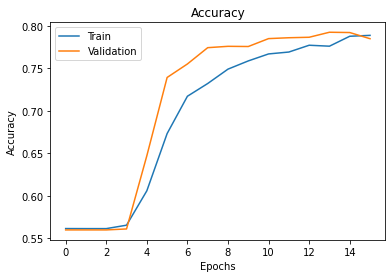

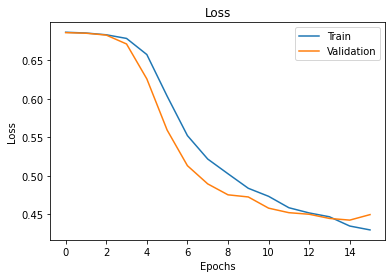

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(["Train", "Validation"])
plt.show()


In [39]:
sentence = ["You just saved my dog's life. Thanks a million.", 
            "You just broke my car window. Great job.", 
            "Hi I am Chandler Bing, I do sarcastic comment when I feel uncomfortable", 
            "I was depressed. He asked me to be happy. I am not depressed anymore."]
sentence_ngram=[]
sentence_clean=pd.DataFrame(sentence)
sentence_clean=remove_punctuation(sentence_clean)
sentence_ngram=sentence_clean[0].apply(lambda x:generate_ngrams(x, 1))
sequences = tokenizer.texts_to_sequences(sentence_ngram)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.40066284]
 [0.6256858 ]
 [0.79935575]
 [0.90956795]]
